# **Explore data**

(last update: 7/5/2025)

---

# **I. Prepare enviroment**

In [53]:
# start pyspark
import findspark
findspark.init()

In [ ]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local")\
          .appName("Spark APIs Exercises")\
          .config("spark.some.config.option", "some-value")\
          .getOrCreate()

sc = spark.sparkContext

In [ ]:
from pyspark.sql import functions as F
from pyspark.sql.functions import col, udf
from pyspark.sql.types import DoubleType

from geopy.distance import great_circle
import folium
from folium.plugins import MarkerCluster
from datetime import timedelta
import seaborn as sns
import matplotlib.pyplot as plt

# **II. Explore data**

We will using Spark Dataframe to explore our data

In [56]:
train_rawData = spark.read.csv("hdfs:///hcmus/22120262/Practical Exercises/HW3/data/train.csv", header=True, inferSchema=True)
test_rawData = spark.read.csv("hdfs:///hcmus/22120262/Practical Exercises/HW3/data/test.csv", header=True, inferSchema=True)

### **1. Summary**

Let see what feature this dataset have.

In [57]:
train_rawData.printSchema()

root
 |-- id: string (nullable = true)
 |-- vendor_id: integer (nullable = true)
 |-- pickup_datetime: timestamp (nullable = true)
 |-- dropoff_datetime: timestamp (nullable = true)
 |-- passenger_count: integer (nullable = true)
 |-- pickup_longitude: double (nullable = true)
 |-- pickup_latitude: double (nullable = true)
 |-- dropoff_longitude: double (nullable = true)
 |-- dropoff_latitude: double (nullable = true)
 |-- store_and_fwd_flag: string (nullable = true)
 |-- trip_duration: integer (nullable = true)



Now we check the summary of these features.

In [58]:
train_rawData.summary().show()

+-------+---------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+
|summary|       id|         vendor_id|   passenger_count|   pickup_longitude|   pickup_latitude|  dropoff_longitude|   dropoff_latitude|store_and_fwd_flag|    trip_duration|
+-------+---------+------------------+------------------+-------------------+------------------+-------------------+-------------------+------------------+-----------------+
|  count|  1458644|           1458644|           1458644|            1458644|           1458644|            1458644|            1458644|           1458644|          1458644|
|   mean|     NULL|1.5349502688798637|1.6645295219395548| -73.97348630489282|40.750920908391734|  -73.9734159469458|   40.7517995149002|              NULL|959.4922729603659|
| stddev|     NULL|0.4987771539074042| 1.314242167823114|0.07090185842270283| 0.032881186257633|0.07064326809720287|0.035890555605

**Dataset Size**  

- The dataset contains 1458644 rows.  
- All column have complete data (no missing data in the summary).  

**Features**

- **`trip_duration`**  

    - Mean: ~959 second (~16 minutes)  

    - Highly skewed:  

        - The maximum duration is over 3.5 million seconds (~40 days), which is clearly an outlier.  

        - 75% of trips are under 1,075 seconds (~18 minutes).

- **`pickup/dropoff_longitude/latitude`**  

    - Some values are clearly invalid:

        - Longitudes as low as -121.93, and latitudes up to 51.88, which are far from NYC.

        - Typical NYC coordinates: longitude ~ -74, latitude ~ 40.7. [Where is New York City, NY, USA on Map?](https://www.latlong.net/place/new-york-city-ny-usa-1848.html)

- **`passenger_count`**

    - Ranges from 0 to 9.

    - Median = 1, meaning most trips had 1 passenger.

    - Trips with 0 passengers are suspicious — likely data errors or special cases.

- **Others feature**

    - Overall, look pretty normal.

**Overall**

- We pay more attention to `trip_duration`, `passenger_count`, `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`. Cause these are the features that are likely to have outlier or error data.

### **2. Additional Features**

##### **2.1. Distance(m)**

Compute travel distance base on longitude and latitude of pickup and dropoff

In [59]:
# Định nghĩa hàm tính khoảng cách sử dụng geopy
def calculate_distance(lat1, lon1, lat2, lon2):
    point1 = (lat1, lon1)
    point2 = (lat2, lon2)
    return great_circle(point1, point2).km  # Trả về khoảng cách tính bằng km

# Đăng ký UDF
distance_udf = udf(calculate_distance, DoubleType())

# Thêm cột khoảng cách vào DataFrame
df_with_distance = train_rawData.withColumn(
    "distance(m)",
    distance_udf(
        col("pickup_latitude"), 
        col("pickup_longitude"), 
        col("dropoff_latitude"), 
        col("dropoff_longitude")
    ) * 1000
)

df_with_distance.describe(["distance(m)"]).show()

+-------+------------------+
|summary|       distance(m)|
+-------+------------------+
|  count|           1458644|
|   mean|3440.8687627509585|
| stddev|   4296.5441000285|
|    min|               0.0|
|    max|1240910.4296218292|
+-------+------------------+



We can see that there is atleast 1 travel distance that cover literally $0$ meter. There is clearly something wrong about it, we will go into this matter later.

##### **2.2. Speed(km/h)**

In [ ]:
df_with_speed = df_with_distance.withColumn(
    "speed(km/h)",
    (F.col("distance(m)") / 1000) / (F.col("trip_duration") / 3600)
)

df_with_speed.describe(["speed(km/h)"]).show()

+-------+------------------+
|summary|       speed(km/h)|
+-------+------------------+
|  count|           1458644|
|   mean|14.423229344163836|
| stddev|14.977545644850895|
|    min|               0.0|
|    max| 9274.849833350512|
+-------+------------------+



Having a `speed(km/h)` value of $0.0$ is quite suspicious; we will look into this matter later.

### **3. Explore Data**

##### **3.1. Trip took over 24h**

We start with the few trips that pretend to have taken several days to complete.

In the summary, we see that there are trip that took over a day (24 hours). The extreme case can took up to 40 days, that is super ridiculous. So we will filter out trip that took more than 24 hours to see what happen.

In [ ]:
day_plus_df = df_with_distance.filter("trip_duration > 24*3600")

day_plus_df.select("pickup_datetime", "dropoff_datetime", "trip_duration").orderBy(
    F.desc("trip_duration")
).show(5)

day_plus_df.describe(["trip_duration"]).show()

+-------------------+-------------------+-------------+
|    pickup_datetime|   dropoff_datetime|trip_duration|
+-------------------+-------------------+-------------+
|2016-02-13 22:46:52|2016-03-25 18:18:14|      3526282|
|2016-01-05 06:14:15|2016-01-31 01:01:07|      2227612|
|2016-02-13 22:38:00|2016-03-08 15:57:38|      2049578|
|2016-01-05 00:19:42|2016-01-27 11:08:38|      1939736|
+-------------------+-------------------+-------------+



+-------+----------------+
|summary|   trip_duration|
+-------+----------------+
|  count|               4|
|   mean|       2435802.0|
| stddev|736600.335105363|
|    min|         1939736|
|    max|         3526282|
+-------+----------------+



We will use geopy library to help us visualize it on a map for clearer view.

In [61]:
# Lấy mẫu dữ liệu
sample_df = day_plus_df.limit(1000).toPandas()

# Tạo bản đồ với kiểu đơn giản (CartoDB)
m = folium.Map(
    location=[sample_df.iloc[0]['pickup_latitude'], sample_df.iloc[0]['pickup_longitude']],
    zoom_start=12,
    tiles='CartoDB positron',  # Bản đồ nhẹ, ít chi tiết
    control_scale=True
)

# Thêm MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

for idx, row in sample_df.iterrows():
    popup_text = f"""
    Distance: {row['distance(m)']:.0f}m<br>
    Duration: {str(timedelta(seconds=row['trip_duration']))}<br>
    Pickup: {row['pickup_latitude']:.4f}, {row['pickup_longitude']:.4f}<br>
    Dropoff: {row['dropoff_latitude']:.4f}, {row['dropoff_longitude']:.4f}
    """
    
    # Vẽ đường đi
    folium.PolyLine(
        locations=[[row['pickup_latitude'], row['pickup_longitude']], 
                 [row['dropoff_latitude'], row['dropoff_longitude']]],
        color='purple',
        weight=1,
        opacity=0.7
    ).add_to(m)
    
    # Điểm đón/trả
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=4,
        color='blue',
        fill=True,
        popup=popup_text
    ).add_to(marker_cluster)
    
    folium.CircleMarker(
        location=[row['dropoff_latitude'], row['dropoff_longitude']],
        radius=4,
        color='red',
        fill=True,
        popup=popup_text
    ).add_to(marker_cluster)

display(m)

These trips have an astonishment duration that take more than 10 days, which is clearly an error in data.  

> $\Rightarrow$ These values should be removed from the training data set for continued exploration and modelling.  

##### **3.2. Trip took nearly 24h**  

In my perspective, I dont think anyone will be taken a taxi drive that last almost a day. Although there is some rare cases this might happen with sufficient long distance travel.

We will define day_long_trip as trip that take over 22h but less than 24h.

In [ ]:
day_trip_df = df_with_distance.where(
    (F.col("trip_duration").between(22*3600, 24*3600)) 
)

day_trip_df.select("trip_duration", "distance(m)").orderBy(
    F.desc("distance(m)")
).show(5)

day_trip_df.describe(["trip_duration"]).show()

+-------------+------------------+
|trip_duration|       distance(m)|
+-------------+------------------+
|        85561|60598.271427628526|
|        85828| 42353.73144137217|
|        85102|28084.514000562773|
|        82134| 22782.38813521169|
|        85347| 22733.15012879659|
+-------------+------------------+
only showing top 5 rows



+-------+------------------+
|summary|     trip_duration|
+-------+------------------+
|  count|              1902|
|   mean| 85476.68822292324|
| stddev|1148.2551225525947|
|    min|             79367|
|    max|             86392|
+-------+------------------+



In [ ]:
day_trip_df = df_with_distance.where(
    (F.col("trip_duration").between(22*3600, 24*3600)) 
)

day_trip_df.select("trip_duration", "distance(m)").orderBy(
    F.desc("distance(m)")
).show(5)

day_trip_df.describe(["trip_duration"]).show()

+-------------+------------------+
|trip_duration|       distance(m)|
+-------------+------------------+
|        85561|60598.271427628526|
|        85828| 42353.73144137217|
|        85102|28084.514000562773|
|        82134| 22782.38813521169|
|        85347| 22733.15012879659|
+-------------+------------------+
only showing top 5 rows



+-------+------------------+
|summary|     trip_duration|
+-------+------------------+
|  count|              1902|
|   mean| 85476.68822292324|
| stddev|1148.2551225525947|
|    min|             79367|
|    max|             86392|
+-------+------------------+



In [ ]:
# Lấy mẫu dữ liệu
sample_df = day_trip_df.sample(False, 0.1).limit(1000).toPandas()

# Tạo bản đồ với kiểu đơn giản (CartoDB)
m = folium.Map(
    location=[sample_df.iloc[0]['pickup_latitude'], sample_df.iloc[0]['pickup_longitude']],
    zoom_start=12,
    tiles='CartoDB positron',  # Bản đồ nhẹ, ít chi tiết
    control_scale=True
)

# Thêm MarkerCluster
marker_cluster = MarkerCluster().add_to(m)

for idx, row in sample_df.iterrows():
    popup_text = f"""
    Distance: {row['distance(m)']:.0f}m<br>
    Duration: {str(timedelta(seconds=row['trip_duration']))}<br>
    Pickup: {row['pickup_latitude']:.4f}, {row['pickup_longitude']:.4f}<br>
    Dropoff: {row['dropoff_latitude']:.4f}, {row['dropoff_longitude']:.4f}
    """
    
    # Vẽ đường đi
    folium.PolyLine(
        locations=[[row['pickup_latitude'], row['pickup_longitude']], 
                 [row['dropoff_latitude'], row['dropoff_longitude']]],
        color='purple',
        weight=1,
        opacity=0.7
    ).add_to(m)
    
    # Điểm đón/trả
    folium.CircleMarker(
        location=[row['pickup_latitude'], row['pickup_longitude']],
        radius=4,
        color='blue',
        fill=True,
        popup=popup_text
    ).add_to(marker_cluster)
    
    folium.CircleMarker(
        location=[row['dropoff_latitude'], row['dropoff_longitude']],
        radius=4,
        color='red',
        fill=True,
        popup=popup_text
    ).add_to(marker_cluster)

display(m)

In [64]:
df_with_speed = df_with_distance.withColumn(
    "speed(km/h)",
    (F.col("distance(m)") / 1000) / (F.col("trip_duration") / 3600)
)

In [65]:
min_trip_df = df_with_speed.filter("trip_duration <= 5*60")

min_trip_df.select("trip_duration", "distance(m)", "speed(km/h)").orderBy(
    F.desc("speed(km/h)")
).show(5)

min_trip_df.describe(["trip_duration", "distance(m)", "speed(km/h)"]).show()

+-------------+------------------+------------------+
|trip_duration|       distance(m)|       speed(km/h)|
+-------------+------------------+------------------+
|            7|18034.430231514885| 9274.849833350512|
|          282|320126.22716019704|4086.7177935344303|
|            2| 783.3481861437955| 1410.026735058832|
|           51|19948.180051437026|1408.1068271602608|
|          279|104760.11870495876|1351.7434671607582|
+-------------+------------------+------------------+
only showing top 5 rows



+-------+------------------+------------------+-----------------+
|summary|     trip_duration|       distance(m)|      speed(km/h)|
+-------+------------------+------------------+-----------------+
|  count|            221916|            221916|           221916|
|   mean|204.52958777194974| 909.7887534204264|16.59572481004905|
| stddev|   68.833244379026| 861.5046134426267|24.81604279298149|
|    min|                 1|               0.0|              0.0|
|    max|               300|320126.22716019704|9274.849833350512|
+-------+------------------+------------------+-----------------+



Here I use about 200 trip of the 1902 trips to keep the map readable and fast execution. Pick up point is blue and drop off point is red.  

We can see that:

- A few longer distances stand out, but they are exception. The 2 major group of trips are those from within New York and from New York to JFK Airport.

- Given the distance to cover in New York, do they really need more than 22 hours to travel? I don’t think so.

> $\Rightarrow$ Decision: We will remove trip_durations longer than 22 hours from the exploration and from the modelling.



##### **3.3. Trip took only a few minutes**

On the other hand of the trip that took too long to be real, there are also trip that only took a few minutes. While such short rides are entirely possible, let’s check their durations and speeds to make sure that they are realistic.

In [ ]:
min_trip_df = df_with_speed.filter("trip_duration <= 5*60")

min_trip_df.select("trip_duration", "distance(m)", "speed(km/h)").orderBy(
    F.asc("speed(km/h)")
).show(5)

min_trip_df.describe(["trip_duration", "distance(m)", "speed(km/h)"]).show()

+-------------+------------------+------------------+
|trip_duration|       distance(m)|       speed(km/h)|
+-------------+------------------+------------------+
|            7|18034.430231514885| 9274.849833350512|
|          282|320126.22716019704|4086.7177935344303|
|            2| 783.3481861437955| 1410.026735058832|
|           51|19948.180051437026|1408.1068271602608|
|          279|104760.11870495876|1351.7434671607582|
+-------------+------------------+------------------+
only showing top 5 rows



+-------+------------------+------------------+-----------------+
|summary|     trip_duration|       distance(m)|      speed(km/h)|
+-------+------------------+------------------+-----------------+
|  count|            221916|            221916|           221916|
|   mean|204.52958777194974| 909.7887534204264|16.59572481004905|
| stddev|   68.833244379026| 861.5046134426267|24.81604279298149|
|    min|                 1|               0.0|              0.0|
|    max|               300|320126.22716019704|9274.849833350512|
+-------+------------------+------------------+-----------------+



By doing so, we can see that there are trips that literally not moving at all. Let see what happen.

In [66]:
zero_dist_df = df_with_speed.filter((F.col("distance(m)") == 0))

zero_dist_df.select("trip_duration", "distance(m)", "passenger_count").orderBy(
    F.desc("trip_duration")
).show(5)

zero_dist_df.describe(["trip_duration", "distance(m)", "passenger_count"]).show()

+-------------+-----------+---------------+
|trip_duration|distance(m)|passenger_count|
+-------------+-----------+---------------+
|        86352|        0.0|              1|
|        85333|        0.0|              3|
|        78288|        0.0|              1|
|         5929|        0.0|              1|
|         4683|        0.0|              2|
+-------------+-----------+---------------+
only showing top 5 rows



+-------+------------------+-----------+------------------+
|summary|     trip_duration|distance(m)|   passenger_count|
+-------+------------------+-----------+------------------+
|  count|              5897|       5897|              5897|
|   mean| 535.5153467865016|        0.0| 1.689842292691199|
| stddev|1952.0940511865558|        0.0|1.3827858113079479|
|    min|                 1|        0.0|                 0|
|    max|             86352|        0.0|                 9|
+-------+------------------+-----------+------------------+



Looking at the top 5 data, we can see that there are trips that literally not moving at all but took up to several days and somehow there are passenger on the taxi too. **We choose not to believe in these data at all.**

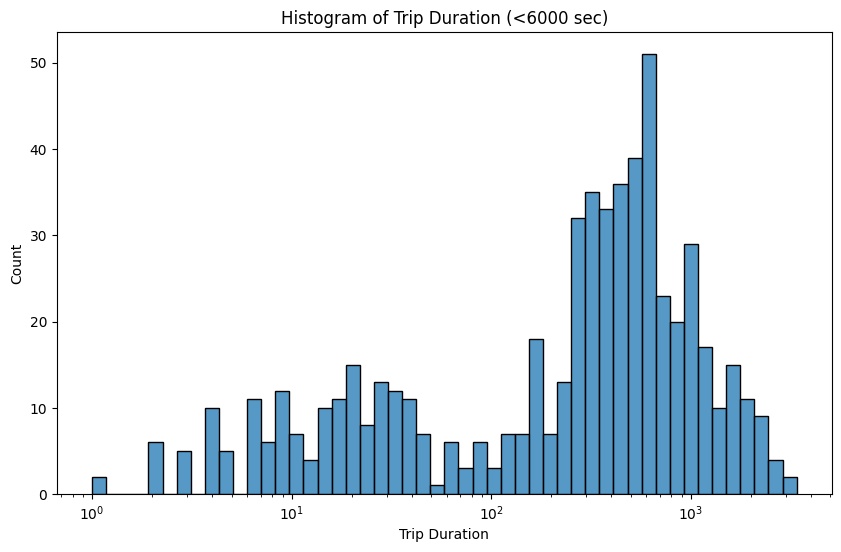

In [ ]:
filtered_df = zero_dist_df.filter(F.col("trip_duration") < 6000)

pandas_df = filtered_df.select("trip_duration").sample(fraction=0.1, seed=42).toPandas()

plt.figure(figsize=(10, 6))
sns.histplot(data=pandas_df, x="trip_duration", bins=50, log_scale=True)
plt.title("Histogram of Trip Duration (<6000 sec)")
plt.xlabel("Trip Duration")
plt.ylabel("Count")
plt.show()

We see that:

- Trip durations of about 15 minutes (900 s) without any distance covered seem hardly possible.

> $\Rightarrow$ We will remove those zero-distance trips that took more than a minute for our continued analysis.